#  Predicting Stock Yields using NLP

Deep learning NLP techniques to map raw text to dense vector representations have had some surprising success in the world of computer natural language processing compared to classical means of encoding text. In this project we will attempt to leverage some of these techniques to help assist us in time series analysis on stock yields. The company we will choose to investigate is Intel (stock ticker: INTC), and the text data we will be leveraging are Intel's SEC forms. Specifically the 8-K form. The 8-K form was chosen because it tends to be the more text rich SEC document when compared to others.

In [1]:
# Setting notebook global variables

import os
import sys
import numpy as np

# Project Paths
project_dir = os.path.split(os.getcwd())[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
# Company Stock Ticker and CIK number
ticker = 'INTC'
CIK = '0000050863'

## Fetching Data

For this project we will need two data sources. Firstly we will need access to Intel's historical stock price data. We will use an API to access this data (since it will be much easier than webscraping it). This gives us two options: Quandl's end of day stock price data API, or Alphavantage's end of day stock price, adjusted time series API. Since Quandl's API costs money we will use Alphavantage's API since its free. The second data source we need is access to Intel's published 8-K forms. For this data source we will web scrape the SEC's database: EDGAR, to gather the necessary data.

### Fetching Stock Price Data

Fetching end of day stock price data from alphavantage: https://www.alphavantage.co/ using fetch_stock_data. Then checking the returned DataFrame object to confirm that the end of day stock price data was successfully loaded into the object.

In [2]:
# Importing Libraries

import os
import io
import json
import requests
import pandas as pd

def get_api_key(source):
    '''
    STILL NEEDS WORK, want to keep same API, but don't know how to link to area where user api keys are stored.
    
    Returns api key for the specific source, :param source:.
    
    :param source: string, name of api source
    
    ---> String, api key for the the specific source :param source:
    '''
    
    path_to_keys = os.path.join(project_dir, 'api_keys.json')
    with open(path_to_keys, 'r') as f:
        api_keys = json.load(f)
    
    return api_keys[source]


def fetch_stock_data(ticker, start_date, end_date=None, source='alphavantage'):
    '''
    Returns end of day stock price DataFrame from various sources.
    
    :param ticker: string, stock ticker
    :param start_date: string, date to start collecting data after, format: YYYY-MM-DD
    :param end_date: string, date to end collecting data at, format: YYYY-MM-DD
    :param source: string 'alphavantage' or 'quandl', specifies the source of the data
    
    ---> DataFrame, of end of day stock price data
    '''
    
    # endpoints for each data source
    source_urls = {'alphavantage': 'https://www.alphavantage.co/query',
                   'quandl': 'https://www.quandl.com/api/v3/datasets/EOD/'}
    
    # API parameters for each data source
    source_params = {'alphavantage': {'function': 'TIME_SERIES_DAILY_ADJUSTED',
                                      'symbol': ticker, 'datatype': 'csv', 'apikey': get_api_key(source),
                                      'outputsize': 'full'},
                     'quandl': {'api_key': get_api_key(source)}}

    # Setting endpoints
    url = source_urls[source]
    if source == 'quandl':
        url = url + ticker + '.csv'
    
    # Settings API parameters
    params = source_params[source]
    
    # Requesting API
    response = requests.get(url, params=params)
    
    # Creating DataFrame
    if source == 'alphavantage':
        date_col = 'timestamp'
    elif source == 'quandl':
        date_col = 'date'    
    df = pd.read_csv(io.StringIO(response.text), parse_dates=[date_col])
    
    # Slicing DataFrame
    if start_date != None:
        df = df.loc[df[date_col] > start_date]
    if end_date != None:
        df = df.loc[df[date_col] <= end_date]
    
    return df

Generating end of day stock price DataFrame.

In [91]:
price_df = fetch_stock_data(ticker, start_date=None)

Checking DataFrame info.

In [92]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 9 columns):
timestamp            5033 non-null datetime64[ns]
open                 5033 non-null float64
high                 5033 non-null float64
low                  5033 non-null float64
close                5033 non-null float64
adjusted_close       5033 non-null float64
volume               5033 non-null int64
dividend_amount      5033 non-null float64
split_coefficient    5033 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 354.0 KB


Checking the first five rows and the last five rows of DataFrame.

In [93]:
price_df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2019-09-26,50.98,51.145,50.348,50.92,50.92,9897846,0.0,1.0
1,2019-09-25,49.75,51.210,49.420,51.02,51.02,19486700,0.0,1.0
2,2019-09-24,51.10,51.180,49.640,49.82,49.82,28197400,0.0,1.0
3,2019-09-23,50.83,51.230,50.390,50.90,50.90,18916600,0.0,1.0
4,2019-09-20,51.60,51.880,50.560,50.72,50.72,37067900,0.0,1.0


In [94]:
price_df.tail()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
5028,1999-10-01,37.125,37.750,36.781,37.469,24.2530,37753600,0.0,1.0
5029,1999-09-30,37.594,38.125,36.688,37.156,24.0507,46111600,0.0,1.0
5030,1999-09-29,38.750,38.969,37.438,37.594,24.3339,46331800,0.0,1.0
5031,1999-09-28,39.000,39.125,37.625,38.750,25.0824,50034400,0.0,1.0
5032,1999-09-27,38.344,39.875,37.875,39.094,25.3049,71235400,0.0,1.0


Looks like everything works out!

### Fetching Text Data

Fetching Intel's 8-K forms from the SEC database. (Link to SEC database, EDGAR: https://www.sec.gov/edgar/searchedgar/companysearch.html) The scraped 8-K forms are saved to the documents folder which lies in the data folder, and are saved in raw text file format. A DataFrame is returned where each row consists of a filing date, and a path to where the 8-K form is saved.

In [3]:
# Importing Libraries

import re
import lxml
import pandas as pd
from bs4 import BeautifulSoup
from datetime import date

def generate_url_df(cik, start_date, end_date=None, form_type='8-k'):
    '''
    Returns a DataFrame  where each row consists of a forms filing date, and an url to the raw text version
    of the form.
    
    :param cik: string, the SEC CIK number for the specific company
    :param start_date: string, date to start collecting data after, format: YYYY-MM-DD
    :param end_date: string, date to end collecting data at, format: YYYY-MM-DD
    :param form_type: string '8-k', '10-k', ..., the type of SEC form to search for
    
    ---> DataFrame, of filing dates and urls to raw text versions of the specified form
    '''
    
    edgar_url = 'https://www.sec.gov/cgi-bin/browse-edgar'
    
    edgar_params = {'action': 'getcompany', 'CIK': cik, 'type': form_type,
                    'owner': 'exclude', 'count': '100', 'output': 'atom', 'start': ''}
    
    edgar_response = requests.get(edgar_url, params=edgar_params)
    
    soup = BeautifulSoup(edgar_response.text, 'lxml')
    
    all_docs = []
    # While the link to the next page existing is true
    while True:
        # Find all document entries on the page
        entries = soup.find_all('entry')
        # For each entry
        for entry in entries:
            # scrape the entry's filing date
            filing_date = entry.find('filing-date').text
            # Add entry url to list if its filing date meets certain requirements, CAN REFACTOR this section
            if (start_date == None) and (end_date == None):
                doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                doc_entry = (filing_date, doc_link)
                all_docs.append(doc_entry)
            elif (start_date == None) and (end_date != None):
                if date.fromisoformat(filing_date) <= date.fromisoformat(end_date):
                    doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                    doc_entry = (filing_date, doc_link)
                    all_docs.append(doc_entry)
            elif (start_date != None) and (end_date == None):
                if date.fromisoformat(filing_date) >= date.fromisoformat(start_date):
                    doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                    doc_entry = (filing_date, doc_link)
                    all_docs.append(doc_entry)
            else:
                if date.fromisoformat(start_date) <= date.fromisoformat(filing_date) <= date.fromisoformat(end_date):
                    doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                    doc_entry = (filing_date, doc_link)
                    all_docs.append(doc_entry)
        # Break loop after scraping entries on the current page, but before requesting on the link to the next page which is potentially none existant
        if soup.find_all('link', {'rel': 'next'}) == []:
            break
        # Find link to the next page, request next page, and update soup object to consist of the next page
        nxt_pg_link = soup.find_all('link', {'rel': 'next'})[0]['href']
        nxt_pg = requests.get(nxt_pg_link)
        soup = BeautifulSoup(nxt_pg.text, 'lxml')
    # Creating DataFrame
    doc_df = pd.DataFrame(all_docs, columns=['filing_date', 'doc_loc'])
    doc_df['filing_date'] = pd.to_datetime(doc_df['filing_date'])
    
    return doc_df

Generating url DataFrame.

In [96]:
doc_df = generate_url_df(CIK, start_date=None)

Checking DataFrame info.

In [97]:
doc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 2 columns):
filing_date    336 non-null datetime64[ns]
doc_loc        336 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 5.4+ KB


Checking the first five, and last five rows of the DataFrame

In [98]:
doc_df.head()

,filing_date,doc_loc
0,2019-09-25,https://www.sec.gov/Archives/edgar/data/50863/...
1,2019-09-13,https://www.sec.gov/Archives/edgar/data/50863/...
2,2019-07-25,https://www.sec.gov/Archives/edgar/data/50863/...
3,2019-05-22,https://www.sec.gov/Archives/edgar/data/50863/...
4,2019-05-09,https://www.sec.gov/Archives/edgar/data/50863/...


In [99]:
doc_df.tail()

,filing_date,doc_loc
331,1998-03-05,https://www.sec.gov/Archives/edgar/data/50863/...
332,1998-01-14,https://www.sec.gov/Archives/edgar/data/50863/...
333,1997-10-15,https://www.sec.gov/Archives/edgar/data/50863/...
334,1995-01-20,https://www.sec.gov/Archives/edgar/data/50863/...
335,1994-12-21,https://www.sec.gov/Archives/edgar/data/50863/...


### Saving Data to Disk

After generating both the end of day stock price DataFrame, and the 8-K url DataFrame we merge them into a DataFrame that contains both sources of data and will represent our full dataset. Each row in this DataFrame contains a date, and the corresponding end of day stock price data, and an url link to an 8-K document if a document was published on the corresponding date. This DataFrame is then cleaned, and saved locally, along with the 8-K forms. The links to the 8-K forms in the DataFrame are also changed to match the local location where the forms are saved.

In [4]:
# Importing Libraries

import os
import requests

def save_doc(url, endpoint):
    '''
    Downloads and saves the text file stored at :param url:, and saves it as its downloaded name in directory
    :param endpoint:.
    
    :param url: String, the url that points to the SEC text file
    :parame endpoint: String, path to location to save SEC filing
    
    ---> String, path to saved document
    '''
    
    if not os.path.isdir(endpoint):
        os.mkdir(endpoint)
    try:
        r = requests.get(url)
    except:
        print('error with url: {}'.format(url))
    fname = url.split('/')[-1]
    with open(os.path.join(endpoint, fname), 'wb') as f:
        f.write(r.content)
    return os.path.join(endpoint, fname)

Merging the end of day stock price DataFrame, and 8-K url DataFrame on their respective date columns.

In [110]:
df = price_df.merge(doc_df, how='outer', left_on='timestamp', right_on='filing_date')

Checking if dataframes were merged properly.

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5059 entries, 0 to 5058
Data columns (total 11 columns):
timestamp            5043 non-null datetime64[ns]
open                 5043 non-null float64
high                 5043 non-null float64
low                  5043 non-null float64
close                5043 non-null float64
adjusted_close       5043 non-null float64
volume               5043 non-null float64
dividend_amount      5043 non-null float64
split_coefficient    5043 non-null float64
filing_date          336 non-null datetime64[ns]
doc_loc              336 non-null object
dtypes: datetime64[ns](2), float64(8), object(1)
memory usage: 474.3+ KB


Checking the first 20 rows and the last 20 rows of the merged DataFrame

In [112]:
df.head(20)

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,filing_date,doc_loc
0,2019-09-26,50.98,51.145,50.348,50.92,50.92,9897846.0,0.0,1.0,NaT,NaN
1,2019-09-25,49.75,51.210,49.420,51.02,51.02,19486700.0,0.0,1.0,2019-09-25,https://www.sec.gov/Archives/edgar/data/50863/...
2,2019-09-24,51.10,51.180,49.640,49.82,49.82,28197400.0,0.0,1.0,NaT,NaN
3,2019-09-23,50.83,51.230,50.390,50.90,50.90,18916600.0,0.0,1.0,NaT,NaN
4,2019-09-20,51.60,51.880,50.560,50.72,50.72,37067900.0,0.0,1.0,NaT,NaN
5,2019-09-19,51.70,51.990,51.500,51.57,51.57,11428400.0,0.0,1.0,NaT,NaN
6,2019-09-18,52.13,52.130,51.160,51.74,51.74,14906800.0,0.0,1.0,NaT,NaN
7,2019-09-17,52.05,52.140,51.350,51.95,51.95,19641100.0,0.0,1.0,NaT,NaN
8,2019-09-16,51.90,52.290,51.700,52.20,52.20,13354600.0,0.0,1.0,NaT,NaN
9,2019-09-13,52.76,53.000,52.230,52.54,52.54,18010800.0,0.0,1.0,2019-09-13,https://www.sec.gov/Archives/edgar/data/50863/...


In [113]:
df.tail(20)

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,filing_date,doc_loc
5039,1999-09-30,37.594,38.125,36.688,37.156,24.0507,46111600.0,0.0,1.0,NaT,NaN
5040,1999-09-29,38.750,38.969,37.438,37.594,24.3339,46331800.0,0.0,1.0,NaT,NaN
5041,1999-09-28,39.000,39.125,37.625,38.750,25.0824,50034400.0,0.0,1.0,NaT,NaN
5042,1999-09-27,38.344,39.875,37.875,39.094,25.3049,71235400.0,0.0,1.0,NaT,NaN
5043,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-04-21,https://www.sec.gov/Archives/edgar/data/50863/...
5044,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-08-10,https://www.sec.gov/Archives/edgar/data/50863/...
5045,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-07-14,https://www.sec.gov/Archives/edgar/data/50863/...
5046,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-07-08,https://www.sec.gov/Archives/edgar/data/50863/...
5047,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-04-14,https://www.sec.gov/Archives/edgar/data/50863/...
5048,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-03-12,https://www.sec.gov/Archives/edgar/data/50863/...


Cleaning the merged DataFrame by droping any rows where there are no end of day stock price data reported. These rows are dropped because these dates would have 8-K form data but no corresponding price date (label) to map to, and thus are not fit for a supervised learning setting.

In [123]:
df.dropna(subset=['timestamp'], inplace=True)

Checking if data was cleaned properly.

In [124]:
df.tail()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,doc_loc
5038,1999-10-01,37.125,37.750,36.781,37.469,24.2530,37753600.0,0.0,1.0,NaN
5039,1999-09-30,37.594,38.125,36.688,37.156,24.0507,46111600.0,0.0,1.0,NaN
5040,1999-09-29,38.750,38.969,37.438,37.594,24.3339,46331800.0,0.0,1.0,NaN
5041,1999-09-28,39.000,39.125,37.625,38.750,25.0824,50034400.0,0.0,1.0,NaN
5042,1999-09-27,38.344,39.875,37.875,39.094,25.3049,71235400.0,0.0,1.0,NaN


Cleaning the merged DataFrame by dropping the filing_date column because it contains redundant information (We already have the timestamp column).

In [115]:
df.drop(['filing_date'], inplace=True, axis=1)

Checking if the data was cleaned properly.

In [125]:
df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,doc_loc
0,2019-09-26,50.98,51.145,50.348,50.92,50.92,9897846.0,0.0,1.0,NaN
1,2019-09-25,49.75,51.210,49.420,51.02,51.02,19486700.0,0.0,1.0,/media/Data/Programs/FinTech/data/documents/00...
2,2019-09-24,51.10,51.180,49.640,49.82,49.82,28197400.0,0.0,1.0,NaN
3,2019-09-23,50.83,51.230,50.390,50.90,50.90,18916600.0,0.0,1.0,NaN
4,2019-09-20,51.60,51.880,50.560,50.72,50.72,37067900.0,0.0,1.0,NaN


Saving the 8-K forms to disk in the documents folder located in the data folder. Updating the doc_loc column of the merged DataFrame to reflect the local location of where the 8-K documents were saved to. This updated DataFrame is then saved in the data folder as raw.csv.

Saving 8-K forms and updating the doc_loc column of the merged DataFrame.

In [120]:
df['doc_loc'] = df['doc_loc'].map(lambda url: save_doc(url, os.path.join(path_to_docs, CIK + 'bytes')) if not pd.isnull(url) else np.nan)

Checking if the merged DataFrame was updated properly by viewing its first 10 rows.

In [126]:
df.head(10)

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,doc_loc
0,2019-09-26,50.98,51.145,50.348,50.92,50.92,9897846.0,0.0,1.0,NaN
1,2019-09-25,49.75,51.210,49.420,51.02,51.02,19486700.0,0.0,1.0,/media/Data/Programs/FinTech/data/documents/00...
2,2019-09-24,51.10,51.180,49.640,49.82,49.82,28197400.0,0.0,1.0,NaN
3,2019-09-23,50.83,51.230,50.390,50.90,50.90,18916600.0,0.0,1.0,NaN
4,2019-09-20,51.60,51.880,50.560,50.72,50.72,37067900.0,0.0,1.0,NaN
5,2019-09-19,51.70,51.990,51.500,51.57,51.57,11428400.0,0.0,1.0,NaN
6,2019-09-18,52.13,52.130,51.160,51.74,51.74,14906800.0,0.0,1.0,NaN
7,2019-09-17,52.05,52.140,51.350,51.95,51.95,19641100.0,0.0,1.0,NaN
8,2019-09-16,51.90,52.290,51.700,52.20,52.20,13354600.0,0.0,1.0,NaN
9,2019-09-13,52.76,53.000,52.230,52.54,52.54,18010800.0,0.0,1.0,/media/Data/Programs/FinTech/data/documents/00...


Saving the updated merged DataFrame to disk as raw.csv.

In [127]:
# Saving modified dataframe to disk
df.to_csv(os.path.join(path_to_data, 'raw_bytes.csv'), index=False)

### Refactoring

In [5]:
# Importing Libraries

import pandas as pd

# Use to prepare dataset as a time series
def to_time_series(df, columns, n_trail=1, n_lead=1):
    '''
    :param df: DataFrame, dataframe object where the columns are the features and labels and the rows are days
    :param columns: list of strings, names of the features and labels (columns of df) to be used in the time series
    :param n_trail: int, number of days behind day 0 that will be used to predict days after day 0
    :param n_lead: int, number of days ahead of day 0 that will be predicted
    
    ---> DataFrame, dataframe object structured like a time series where each row represents an element in the time
                    series, and each column is a feature or label a certain amount of days in the future or past.
    '''
    df = df[columns]
    dfs = []
    col_names = []
    
    # Create trailing columns
    for i in range(n_trail, 0, -1):
        dfs.append(df.shift(-i))
        col_names += [(col_name + '(t-{})'.format(i)) for col_name in columns]
        
    # Create leading columns
    for i in range(0, n_lead+1):
        dfs.append(df.shift(i))
        col_names += [(col_name + '(t+{})'.format(i)) for col_name in columns]
        
    agg = pd.concat(dfs, axis=1)
    agg.columns = col_names
    
    #agg.dropna(inplace=True)
    
    return agg
    

## Exploratory Data Analysis

Before moving onto the modeling phase we will check and explore our data a bit. Just to get a feel for the data we are dealing with and ensure there is nothing deeply flawed with our data. Since we have two different types of data, we will inspect each type seperately

In [24]:
# Importing Libraries

import matplotlib.pyplot as plt

### Pricing Data

The first things we will check for our pricing data are a plot of the time series of our adjusted closing prices along with its distribution to check and see if there is anything unusual, and if the distribution conforms to our expectations of this type of data. We will then check these types of plots for other types of data.

Loading the dataframe with the pricing data.

In [66]:
# Loading DataFrame from disk
df = pd.read_csv(os.path.join(path_to_data, 'raw.csv'), parse_dates=['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5042 entries, 0 to 5041
Data columns (total 10 columns):
timestamp            5042 non-null datetime64[ns]
open                 5042 non-null float64
high                 5042 non-null float64
low                  5042 non-null float64
close                5042 non-null float64
adjusted_close       5042 non-null float64
volume               5042 non-null float64
dividend_amount      5042 non-null float64
split_coefficient    5042 non-null float64
doc_loc              320 non-null object
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 394.0+ KB


Checking some basic statistics of the dataset.

In [67]:
df.describe()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,5042.000000,5042.000000,5042.000000,5042.000000,5042.000000,5.042000e+03,5042.000000,5042.000000
mean,29.134800,29.525539,28.749346,29.131880,22.913637,4.967110e+07,0.002394,1.000198
std,11.218045,11.407489,11.043233,11.218809,10.939474,2.623932e+07,0.022499,0.014083
min,12.170000,12.630000,12.050000,12.080000,8.615100,1.155400e+06,0.000000,1.000000
25%,21.220000,21.450000,21.002225,21.210000,15.253350,2.966888e+07,0.000000,1.000000
50%,25.850000,26.140000,25.565000,25.880000,18.698900,4.708465e+07,0.000000,1.000000
75%,34.189500,34.540250,33.747500,34.197500,28.968700,6.309482e+07,0.000000,1.000000
max,75.625000,75.828000,73.625000,74.875000,58.069900,3.093476e+08,0.315000,2.000000


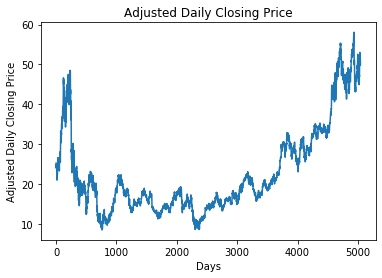

In [68]:
# Plotting Adjusted Daily Closing Price with respect to time.
days = list(range(len(df)))
adj_close = df.sort_values(by='timestamp', ascending=True)['adjusted_close'].tolist()

fig, ax = plt.subplots()
ax.plot(days, adj_close)
ax.set_title('Adjusted Daily Closing Price')
ax.set_xlabel('Days')
ax.set_ylabel('Adjusted Daily Closing Price')
plt.show()

It appears that after the company went IPO, the price of the stock climbed for about the first year, then crashed over the period of another year. Afterwards the price continued to fluctuated about an average value for about 5 years, then started slowly climbing again to the current price. There doesn't seem to be anything unusual about this behavior in my opinion.

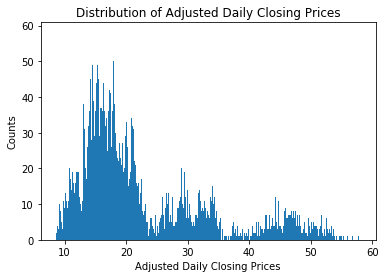

In [69]:
# Plotting the distribution of Adjusted Daily Closing Prices
fig, ax = plt.subplots()
ax.hist(df['adjusted_close'].tolist(), bins=500)
ax.set_title('Distribution of Adjusted Daily Closing Prices')
ax.set_xlabel('Adjusted Daily Closing Prices')
ax.set_ylabel('Counts')
plt.show()

The distribution of Adjusted Daily Closing Prices looks like it could be log-normal which is the distribution type that prices should approximately follow.

In [70]:
# Calculating the log adjusted closing prices, and log adjusted daily returns
df['log_adj_close'] = np.log(df['adjusted_close'])
df['log_adj_daily_returns'] = df['log_adj_close'].shift(1) - df['log_adj_close']
df.dropna(subset=['log_adj_daily_returns'], inplace=True)

We are calculating the log of Adjusted Daily Closing Price as well as the difference between the logs of Adjusted Daily Closing Price because if Adjusted Daily Closing Price is log-normal distributed, then the distributions of these values should be normally distributed. This is because the log of a log-normally distributed variable should be normally distributed, and the sum (or difference) of independently normally distributed variables should also be normally distributed. (We are assuming each Adjusted Daily Closing Price is independently distributed from others, which is approximately true.)

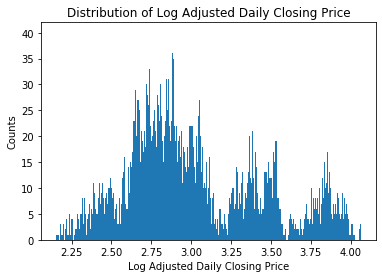

In [71]:
# Plotting the distribution of Log Adjusted Daily Closing Price
fig, ax = plt.subplots()
ax.hist(df['log_adj_close'].tolist(), bins=500)
ax.set_title('Distribution of Log Adjusted Daily Closing Price')
ax.set_xlabel('Log Adjusted Daily Closing Price')
ax.set_ylabel('Counts')
plt.show()

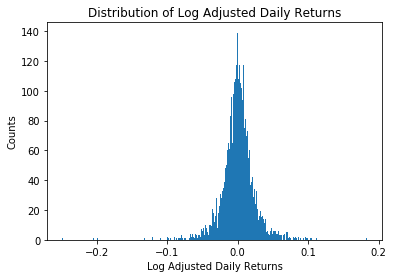

In [72]:
# Plotting the distribution of Log Adjusted Daily Returns
fig, ax = plt.subplots()
ax.hist(df['log_adj_daily_returns'].tolist(), bins=500)
ax.set_title('Distribution of Log Adjusted Daily Returns')
ax.set_xlabel('Log Adjusted Daily Returns')
ax.set_ylabel('Counts')
plt.show()

Although the distribution of log Adjusted Daily Closing Price doesn't appear to be too normal, the distribution of Log Adjusted Daily Returns appears to visually fit a normal distribution well. Therefore we are probably safe in make our assumptions about log-normal prices, and independently distributed prices.

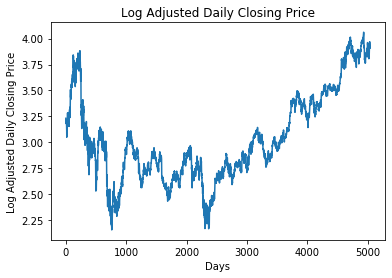

In [73]:
# Plotting Adjusted Daily Returns with respect to time
days = list(range(len(df)))
log_adj_close = df.sort_values(by='timestamp', ascending=True)['log_adj_close'].tolist()

fig, ax = plt.subplots()
ax.plot(days, log_adj_close)
ax.set_title('Log Adjusted Daily Closing Price')
ax.set_xlabel('Days')
ax.set_ylabel('Log Adjusted Daily Closing Price')
plt.show()

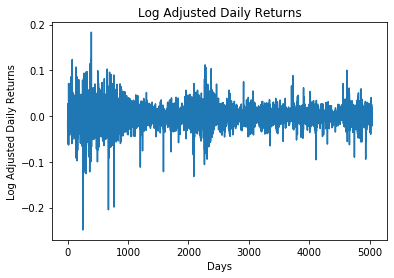

In [74]:
# Plotting Adjusted Daily Returns with respect to time
days = list(range(len(df)))
log_adj_daily_returns = df.sort_values(by='timestamp', ascending=True)['log_adj_daily_returns'].tolist()

fig, ax = plt.subplots()
ax.plot(days, log_adj_daily_returns)
ax.set_title('Log Adjusted Daily Returns')
ax.set_xlabel('Days')
ax.set_ylabel('Log Adjusted Daily Returns')
plt.show()

The time series of log Adjusted Daily Closing Price appears similar to the time series of Adjusted Daily Closing Price. This is as expected and not unusual because we are just taking a log a variable and thus the overall shape of the graph should not be affected. On the other hand the time series of log Adjusted Daily Returns appears to fluctuate about zero where the magnitude of the fluctuation does not change too much except for at a few pivitol days. This makes sense with respect to its Gaussian distribution, because the Gaussian distribution alots small probabilities to large magnitudes of log Adjusted Daily Return which means there should not be too many days where we see a huge value for log Adjusted Daily Return.

### Text Data

The first thing we will check are the lengths of our raw documents.

In [63]:
# Path to Intel's 8-K forms
intel_docs_path = os.path.join(path_to_docs, CIK)

In [64]:
# Constructing doc_lengths: a list of lengths of Intel's 8-K forms before they are normalized
doc_lengths_paths_dict = {}

for doc_name in os.listdir(intel_docs_path):
    doc_path = os.path.join(intel_docs_path, doc_name)
    with open(doc_path, 'r') as f:
        raw_doc_text = f.read()
    doc_lengths_paths_dict[len(raw_doc_text)] = doc_path

In [65]:
print("Largest document has: {} charcters".format(max(doc_lengths_paths_dict.keys())))
print("Smallest document has: {} charcters".format(min(doc_lengths_paths_dict.keys())))
largest_doc_path = doc_lengths_paths_dict[max(doc_lengths_paths_dict.keys())]
smallest_doc_path = doc_lengths_paths_dict[min(doc_lengths_paths_dict.keys())]

Largest document has: 75072520 charcters
Smallest document has: 4638 charcters


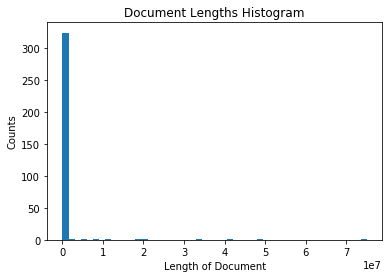

In [66]:
fig, ax = plt.subplots()
ax.hist(doc_lengths_paths_dict.keys(), bins=50)
ax.set_title('Document Lengths Histogram')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Counts')
plt.show()

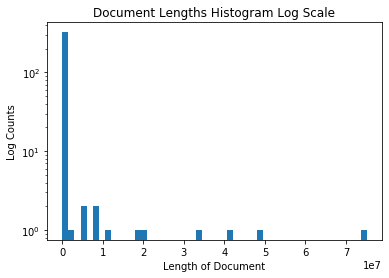

In [67]:
fig, ax = plt.subplots()
ax.hist(doc_lengths_paths_dict.keys(), bins=50, log=True)
ax.set_title('Document Lengths Histogram Log Scale')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Log Counts')
plt.show()

From the above histograms, it appears very few of our documents contain over 30 million characters. Most of our documents seem to have 10 million characters or less with a large emphasize on documents with less than 1 million characters. Since a single characters is about 1 byte in memory, our largest document should be about 75 MB. Therefore we should expect all of our documents to be able to fit into our RAM of 32 GB

#### Text Preprocessing

To preprocess our text data, we will first strip it of its x/html tags if the data is encoded this way. Next we will un accent its accented characters, lower case the entire document, and replace all newline/carriage returns with spaces. Next we will strip it of its characters that are not alphanumeric, periods, dollar symbols, or percent symbols. Afterwards we will reduce all words to their dictionary lemmas, and strip the document of its stop words (see stop word list for spacy en_cor_web_sm model). Finally we will replace all whitespace characters with regular space characters.

The structure of our 8-K filing document involves an xml SEC document header packed with metadata about the filing, and one or multiple xml `<DOCUMENT>` tags. These `<DOCUMENT>` tags contain different types of data that are bundled up into the complete submission for the 8-K filing. The data types stored in these `<DOCUMENT>` tags can range from everything including: regular text data such as html, to binary blob data such as jpg images and pdfs. The structure of these `<DOCUMENT>` tags involve a few meta data tags, none of which involve specifying the encoding type of the data that `<DOCUMENT>` tag stores, and a `<TEXT>` tag that stores the actual data.

Since the inclusion of binary blobs in the markdown prevents easy parsing of the filing structure with lxml, we will result to python re statements to extract the relevant `<DOCUMENT>` tags. Though because the meta data tags enclosed in a `<DOCUMENT>` tag do not specify the encoding type of the data enclosed in the `<TEXT>` tag, there does not appear to be an easy quick general solution that extracts the text data `<DOCUMENT>` tags and avoids the binary blob like `<DOCUMENT>` tags. Because of the above issues we will have to suffice ourselves with extracting only the `<DOCUMENT>` tag that contain's the meta data open tag `<TYPE>8-K`. This specific `<DOCUMENT>` tag always contains text data, and represents the data that is used to generate the SEC 8-K form containing the information that is mandated by the SEC, and excluding the exhibit information that is not mandated by the SEC and is given by the company's discretion. Since this `<DOCUMENT>` tag contains all the mandated information by the SEC for a given 8-K filing, we are still extracting the important information bundled in the filing even though we are not extracting all of the textual information.

In [82]:
# Importing Libraries

import re
import lxml
import unicodedata
import en_core_web_sm
from bs4 import BeautifulSoup

nlp = en_core_web_sm.load(disable=['parser', 'ner'])
#nlp.max_length = 400000000

def extract_8k(doc):
    eight_k = re.findall('<DOCUMENT>\n<TYPE>8-K.*?</DOCUMENT>', doc, re.DOTALL | re.IGNORECASE)
    return eight_k

def extract_html(doc):
    html = re.findall('<HTML(?:>| .*?>).*?</HTML>', doc, re.DOTALL | re.IGNORECASE)
    return html

def strip_tags(doc):
    # extracting 8-K <DOCUMENT> tag from the filing
    eight_k = extract_8k(doc)
    assert len(eight_k) == 1, 'Check re for 8-K extraction, either multiple 8-K DOCUMENT tags or bad re'
    
    # extracting <html> tag if any
    html = extract_html(eight_k[0])
    assert 0 <= len(html) <= 1, 'Check re for extracting html tags'
    
    # if html exists
    if len(html) == 1:
        html = html[0]
        soup = BeautifulSoup(html, 'lxml')
        stripped = soup.get_text()
    else:
        soup = BeautifulSoup(eight_k[0], 'xml')
        stripped = soup.find('TEXT').get_text()
    
    return stripped

def strip_accented_chars(doc):
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return doc

def strip_special_chars(doc):
    doc = re.sub('[^$A-Za-z0-9%.\s\']', '', doc)
    return doc

def lemmatize(doc):
    document = nlp(doc)
    doc = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in document])
    return doc

def strip_stop_words(doc):
    document = nlp(doc)
    doc = ' '.join([word.text for word in document if not word.is_stop])
    return doc
    
def normalize_document(doc, tags_strip=True, accent_char_strip=True, lower_case=True,
                       no_newlines=True, special_char_strip=True, lemmatize_words=True,
                       remove_stop_words=True, strip_extra_spaces=True, debug=False):
    '''
    Preprocesses the document :param doc: and returns the normalized document.
    
    :param doc: string, document to normalize
    :param xml_strip: bool, set to True to strip the xml tags
    :param accent_char_strip: bool, set to True to replace accented characters with their non accented versions
    :param lower_case: bool, set to True to lower case the document.
    :param no_newlines: bool, set to True to remove all newlines characters and replace them with spaces
    :param special_char_strip: bool, set to True to remove all characters that are 
                                     not letters, numbers, $, ., %, or spaces
    :param lemmatize_words: bool, set to True to map each word to its lemma
    :param remove_stop_words: bool, set to True to remove stop words
    :param strip_extra_spaces: bool, set to True to replace multiple spaces with one
    
    ---> string, normalized document
    '''
    if debug:
        print('raw length of doc: {}'.format(len(doc)))
        
    # stripping tags
    if tags_strip:
        doc = strip_tags(doc)
    if debug:
        print('stripped tag length: {}'.format(len(doc)))
    
    # stripping accented characters
    if accent_char_strip:
        doc = strip_accented_chars(doc)
    if debug:
        print('altered accents length: {}'.format(len(doc)))
        
    # lower casing the document
    if lower_case:
        doc = doc.lower()
    if debug:
        print('lower casing length: {}'.format(len(doc)))
    
    # removing new lines and carriage returns and replacing them with spaces
    if no_newlines:
        doc = re.sub(r'[\r|\n|\r\n]+', ' ', doc)
    if debug:
        print('removing newlines length: {}'.format(len(doc)))
    
    # removing special characters
    if special_char_strip:
        doc = strip_special_chars(doc)
    if debug:
        print('strip special char length: {}'.format(len(doc)))
    
    # lemmatizing the words
    if lemmatize_words:
        doc = lemmatize(doc)
    if debug:
        print('lemmatized doc length: {}'.format(len(doc)))
    
    # stripping stop words
    if remove_stop_words:
        doc = strip_stop_words(doc)
    if debug:
        print('removed stop word length: {}'.format(len(doc)))
    
    # removing extra whitespace
    if strip_extra_spaces:
        doc = re.sub(' +', ' ', doc)
    if debug:
        print('removed extra space length: {}'.format(len(doc)))
    
    return doc

The first thing we will need to confirm is if the re's we constructed for extracting a documents 8-K component, and the html tag (if they exist) works/still works. For the time being the data we will use from each document will only be the text embedded in the 8-K component of the document.

In [69]:
# Checking the extract_8k function
checksout = True
for doc_name in os.listdir(intel_docs_path):
    doc_path = os.path.join(intel_docs_path, doc_name)
    with open(doc_path, 'r') as f:
        raw_doc_text = f.read()
    num_of_8k = len(extract_8k(raw_doc_text))
    if num_of_8k != 1:
        checksout = False
        print('Filing: {0}, contains: {1} 8-K portions, check re of extract_8k, and document.'.format(doc_path, num_of_8k))

if checksout:
    print('The re in extract_8k seems to checkout.')

The re in extract_8k seems to checkout.


In [70]:
# Checking the extract_html function
checksout = True
for doc_name in os.listdir(intel_docs_path):
    doc_path = os.path.join(intel_docs_path, doc_name)
    with open(doc_path, 'r') as f:
        raw_doc_text = f.read()
    eight_k = extract_8k(raw_doc_text)[0]
    num_html_tags = len(extract_html(eight_k))
    if not (0 <= num_html_tags <= 1):
        checksout = False
        print('Filing: {0}, contains: {1} html tags, check re of extract_html, and document.'.format(doc_path, num_html_tags))

if checksout:
    print('The re in extract_html seems to checkout.')

The re in extract_html seems to checkout.


In each 8-K filing there should be only one `<DOCUMENT>...</DOCUMENT>` tag that contains a:`<TYPE>8-K` tag. There should also be ONLY one `<html ...>...</html>` tag if the document tag contains an html tag. The above cells verify if any of these conditions are violated on the current dataset.

The next thing we will investigate are the lengths of our normalized texts.

In [71]:
# Constructing norm_doc_lengths: a list of lengths of Intel's 8-K forms after they are normalized
norm_doc_lengths_paths_dict = {}

for doc_name in os.listdir(intel_docs_path):
    doc_path = os.path.join(intel_docs_path, doc_name)
    with open(doc_path, 'r') as f:
        raw_doc_text = f.read()
    norm_doc = normalize_document(raw_doc_text)
    norm_doc_lengths_paths_dict[len(norm_doc)] = doc_path

In [72]:
print("Largest document has: {} charcters".format(max(norm_doc_lengths_paths_dict.keys())))
print("Smallest document has: {} charcters".format(min(norm_doc_lengths_paths_dict.keys())))
largest_norm_doc_path = norm_doc_lengths_paths_dict[max(norm_doc_lengths_paths_dict.keys())]
smallest_norm_doc_path = norm_doc_lengths_paths_dict[min(norm_doc_lengths_paths_dict.keys())]

Largest document has: 45788 charcters
Smallest document has: 1120 charcters


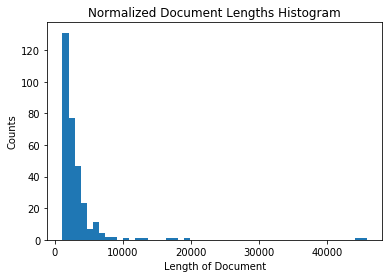

In [74]:
fig, ax = plt.subplots()
ax.hist(norm_doc_lengths_paths_dict.keys(), bins=50)
ax.set_title('Normalized Document Lengths Histogram')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Counts')
plt.show()

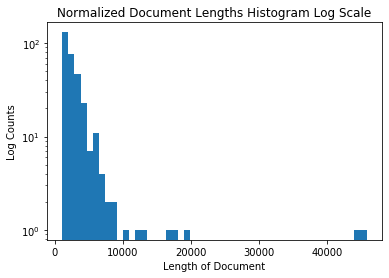

In [75]:
fig, ax = plt.subplots()
ax.hist(norm_doc_lengths_paths_dict.keys(), bins=50, log=True)
ax.set_title('Normalized Document Lengths Histogram Log Scale')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Log Counts')
plt.show()

Nothing seems to stand out in these histograms so far. The next things we will check are the documents that correspond to the extremums of our histograms just to see if anything stands out about these normalized documents.

In [76]:
# Checking Largest Normalized Document
with open(largest_norm_doc_path) as f:
    largest_norm_doc_raw = f.read()

largest_norm_doc = normalize_document(largest_norm_doc_raw, debug=True)
print()
print(largest_norm_doc)  

raw length of doc: 82403
stripped tag length: 80448
altered accents length: 80448
lower casing length: 80448
removing newlines length: 80204
strip special char length: 78968
lemmatized doc length: 80921
removed stop word length: 60382
removed extra space length: 45788

 united state security exchange commission washington d.c . 20549 form 8k current report pursuant section 13 15d security exchange act 1934 date report november 10 2004 date early event report intel corporation exact registrant specify charter delaware 006217 941672743 state commission file irs employer incorporation number identification . 2200 mission college blvd . santa clara 950528119 address principal executive office zip code 408 7658080 registrant telephone number include area code check appropriate box form 8k filing intend simultaneously satisfy filing obligation registrant follow provision write communication pursuant rule 425 security act 17 cfr 230.425 solicit material pursuant rule 14a12 exchange act 17 cfr

In [81]:
# Checking Smallest Normalized Document
with open(smallest_norm_doc_path) as f:
    smallest_norm_doc_raw = f.read()

smallest_norm_doc = normalize_document(smallest_norm_doc_raw, debug=True)
print()
print(smallest_norm_doc)

raw length of doc: 8749
stripped tag length: 2281
altered accents length: 2281
lower casing length: 2281
removing newlines length: 2228
strip special char length: 2063
lemmatized doc length: 2087
removed stop word length: 1908
removed extra space length: 1120

 security exchange commission washington d.c . 20549 form 8k current report pursuant section 13 15 d security exchange act 1934 date report december 20 1994 intel corporation exact registrant specify charter delaware 06217 941672743 state incorporation commission file number irs employer identification . 2200 mission college blvd . santa clara 95052 address principal executive office 4087658080 registrant telephone number 2 item 5 . event . 5.1 attach hereto exhibit 99.1 incorporate reference press release issue intel corporation december 20 1994 relate adoption uponrequ replacement policy pentiumtm processor material unspecified charge earning intel corporation fourth quarter fiscal year end december 31 1994 . item 7 . financial

Nothing seems out of the ordinary about these two normalized documents. The relevant information of the 8-K Document sections of the 8-K filings are still there. The Item #.## sections are still existant in these normalized documents, thus they still contain the information that will be important for analysis, albiet with some noise still

### Conclusion

From our exploratory analysis we can conclude that our pricing data seems to fit the assumptions one usually assumes about stock pricing data. This means that the stock pricing data should be distributed log-normally and implies that the log returns of a stock over a period of time should be distributed normally. Our exploratory analysis of our text data shows there is nothing unusual about our raw text data, and it should fit into memory fine. It also shows that our text preprocessing methods still preserve the important parts of our text data and thus should not pose a future issue for analysis. From these findings we can conclude that our raw text data is useable, our text preprocessing methods are useable, and our price data is useable. Since the log returns of our pricing data (Adjusted Daily Closing Price) appear to fit a Gaussian distribution pretty well, our predictor variable in analysis should be log returns (as opposed to Adjusted Daily Closing Price) because the Gaussian distribution has some nice mathematical properties that might be leveraged further on in the future.

## Feature Encoding and Selection